In [4]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import json
import shutil
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [5]:
# ==================== CONFIG ====================
# Model settings
MODEL_NAME = "distilbert-base-uncased"  # or "bert-base-uncased"
MAX_LENGTH = 64

# Dataset settings
TRAIN_SUBSET = 50000      # Use 50k from 120k available
VAL_SUBSET = 1000         # Validation samples
TEST_SUBSET = 1000        # Test samples

# Training settings
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 3e-5

# Paths
TRAIN_CSV = "/kaggle/input/ag-news-classification-dataset/train.csv"
TEST_CSV = "/kaggle/input/ag-news-classification-dataset/test.csv"
OUTPUT_DIR = "/kaggle/working/bert-news-classifier"

print(f"Config set:")
print(f"  Model: {MODEL_NAME}")
print(f"  Train samples: {TRAIN_SUBSET}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Max length: {MAX_LENGTH}")

Config set:
  Model: distilbert-base-uncased
  Train samples: 50000
  Batch size: 64
  Epochs: 2
  Max length: 64


In [6]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Loaded train: {len(train_df):,} rows")
print(f"Loaded test: {len(test_df):,} rows")

# Process data
train_df["text"] = train_df["Title"].astype(str) + " " + train_df["Description"].astype(str)
test_df["text"] = test_df["Title"].astype(str) + " " + test_df["Description"].astype(str)

# Convert labels to 0-indexed
train_df["label"] = train_df["Class Index"] - 1
test_df["label"] = test_df["Class Index"] - 1

# Keep only needed columns
train_df = train_df[["text", "label"]]
test_df = test_df[["text", "label"]]

print(f"\nProcessed train: {len(train_df)} rows")
print(f"Label distribution:\n{train_df['label'].value_counts().sort_index()}")

Loaded train: 120,000 rows
Loaded test: 7,600 rows

Processed train: 120000 rows
Label distribution:
label
0    30000
1    30000
2    30000
3    30000
Name: count, dtype: int64


In [7]:
# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Split test into validation and test
test_val_split = test_dataset.train_test_split(test_size=0.5, seed=42)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": test_val_split["train"],
    "test": test_val_split["test"]
})

label_names = ["World", "Sports", "Business", "Sci/Tech"]
num_labels = 4

print("Dataset structure:")
print(dataset)

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3800
    })
})


In [8]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Tokenize function
def preprocess_function(examples):
    return tokenizer(
        examples["text"], 
        truncation=True, 
        max_length=MAX_LENGTH,
        padding=False  # Dynamic padding
    )

# Apply tokenization
tokenized_dataset = dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=["text"]
)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

print("Tokenized dataset:")
print(tokenized_dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3800 [00:00<?, ? examples/s]

Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3800
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3800
    })
})


In [9]:
# Create subsets
train_data = tokenized_dataset["train"].shuffle(seed=42).select(range(TRAIN_SUBSET))
val_data = tokenized_dataset["validation"].shuffle(seed=42).select(range(VAL_SUBSET))
test_data = tokenized_dataset["test"].shuffle(seed=42).select(range(TEST_SUBSET))

print(f"Final splits:")
print(f"  Train: {len(train_data)}")
print(f"  Validation: {len(val_data)}")
print(f"  Test: {len(test_data)}")

# Verify
expected_steps = len(train_data) // BATCH_SIZE
print(f"\nExpected steps per epoch: {expected_steps}")
print(f"Total steps ({EPOCHS} epochs): {expected_steps * EPOCHS}")

Final splits:
  Train: 50000
  Validation: 1000
  Test: 1000

Expected steps per epoch: 781
Total steps (2 epochs): 1562


In [10]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label={i: name for i, name in enumerate(label_names)},
    label2id={name: i for i, name in enumerate(label_names)}
).to(device)

print(f"Model: {MODEL_NAME}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.outp

Model: distilbert-base-uncased
Parameters: 109,485,316


In [11]:
# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "f1_weighted": f1_score(labels, predictions, average="weighted")
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=128,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,
    seed=42
)

print("Training args set:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")

Training args set:
  Batch size: 64
  Epochs: 2


In [12]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# Train
print("Starting training...")
trainer.train()

# Save model
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"\n✅ Model saved to {OUTPUT_DIR}")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.626300,0.495599,0.822000,0.821375,0.817970
2,0.329100,0.353435,0.883000,0.883959,0.882718



✅ Model saved to /kaggle/working/bert-news-classifier


In [13]:
# Evaluate on test set
results = trainer.evaluate(test_data)
print("\nTest Results:")
for k, v in results.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")

# Predictions
pred_output = trainer.predict(test_data)
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=-1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))


Test Results:
  eval_loss: 0.2828
  eval_accuracy: 0.9050
  eval_f1_macro: 0.9045
  eval_f1_weighted: 0.9045
  eval_runtime: 2.2231
  eval_samples_per_second: 449.8260
  eval_steps_per_second: 1.7990
  epoch: 2.0000

Classification Report:
              precision    recall  f1-score   support

       World       0.90      0.94      0.92       242
      Sports       0.96      0.98      0.97       255
    Business       0.86      0.87      0.87       235
    Sci/Tech       0.89      0.84      0.86       268

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.90      0.91      0.90      1000



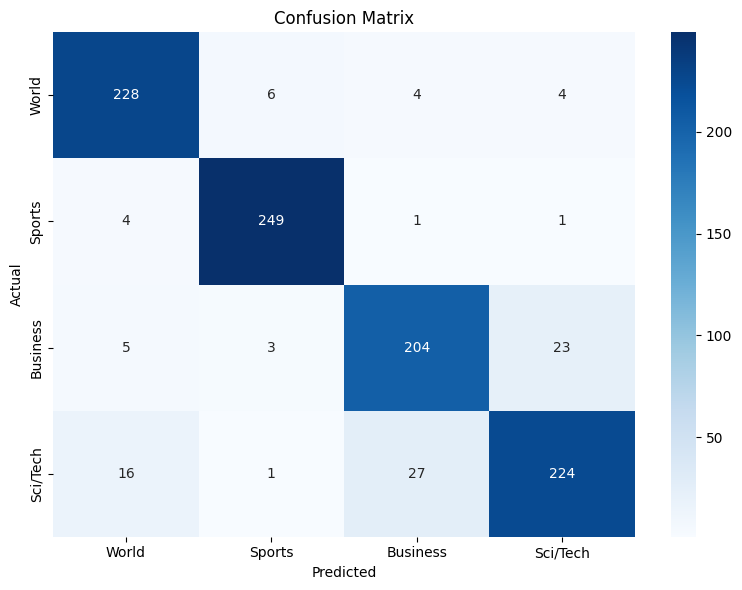

In [14]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=300)
plt.show()

In [16]:
# Save label mapping
with open(f"{OUTPUT_DIR}/label_mapping.json", "w") as f:
    json.dump({
        "id2label": {i: name for i, name in enumerate(label_names)},
        "label2id": {name: i for i, name in enumerate(label_names)}
    }, f, indent=2)
    

# Create zip
shutil.make_archive(OUTPUT_DIR, "zip", OUTPUT_DIR)
print(f"✅ Created: {OUTPUT_DIR}.zip")
print("Download from Output folder!")

✅ Created: /kaggle/working/bert-news-classifier.zip
Download from Output folder!
